## Identification and classification of damaged/flooded buildings from post-hurricane satellite images

## 1.1 Data Wrangling : Introduction

After a hurricane or major storm, damage assessment is critical to emergency managers for efficient response and resource allocation. One way to gauge the damage extent is to quantify the number of flooded/damaged buildings, which is traditionally done by ground survey. This process can be labor-intensive, time-consuming as well as some areas can be inaccessible due to flooding.

Another way to assess hurricane damage level is flood detection through synthetic aperture radar (SAR) images and imagery taken from satellites. However, this process still relies on human visual inspection of captured imagery, which is generally time-consuming and unreliable during an evolving disaster. An automated damage/flood detection of buildings would be very beneficial.  The main objective of this project is therefore, to identify and classify damaged building using computer vision techniques.

Dataset for this project is a satellite imagery data of the Greater Houston area before and after Hurricane Harvey in 2017. The images are labeled as either damaged or undamaged and they are grouped into 4 groups as described below:

- Training data: the training data contains 5000 images of each class 
- validation: the validation data with 1000 images of each class
- Test: balanced test data with 1000 images of each class
- Test-another: unbalanced test data with 8000/1000 images of damaged/undamaged classes

The project will be divided into several notebooks including:

    - Data wrangling
    - EDA
    - Pre-processing and feature engineering
    - Modeling


## 1.2 Import relevant libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image
from skimage.io import imread
from skimage.util import montage
from tqdm import tqdm
import cv2

## 1.3 Read satellite image data

In [57]:
directory = Path('./raw_data/')
sat_image_df = pd.DataFrame({'path': list(directory.glob('**/*.jp*g'))})

In [58]:
pd.set_option('display.max_colwidth', None)
sat_image_df.head()

,path
0,raw_data/test/no_damage/-95.63609699999999_29.843807.jpeg
1,raw_data/test/no_damage/-95.237647_29.559739.jpeg
2,raw_data/test/no_damage/-95.63993599999999_29.837821.jpeg
3,raw_data/test/no_damage/-95.64638599999999_29.832628000000003.jpeg
4,raw_data/test/no_damage/-95.631831_29.849646999999997.jpeg


In [59]:
# populating the data frame
sat_image_df['damage'] = sat_image_df['path'].map(lambda x: x.parent.stem)
sat_image_df['data_split'] = sat_image_df['path'].map(lambda x: x.parent.parent.stem)
sat_image_df['location'] = sat_image_df['path'].map(lambda x: x.stem)
sat_image_df['lon'] = sat_image_df['location'].map(lambda x: float(x.split('_')[0]))
sat_image_df['lat'] = sat_image_df['location'].map(lambda x: float(x.split('_')[1]))
sat_image_df.head()

,path,damage,data_split,location,lon,lat
0,raw_data/test/no_damage/-95.63609699999999_29.843807.jpeg,no_damage,test,-95.63609699999999_29.843807,-95.636097,29.843807
1,raw_data/test/no_damage/-95.237647_29.559739.jpeg,no_damage,test,-95.237647_29.559739,-95.237647,29.559739
2,raw_data/test/no_damage/-95.63993599999999_29.837821.jpeg,no_damage,test,-95.63993599999999_29.837821,-95.639936,29.837821
3,raw_data/test/no_damage/-95.64638599999999_29.832628000000003.jpeg,no_damage,test,-95.64638599999999_29.832628000000003,-95.646386,29.832628
4,raw_data/test/no_damage/-95.631831_29.849646999999997.jpeg,no_damage,test,-95.631831_29.849646999999997,-95.631831,29.849647


## 1.4 Visualize the data

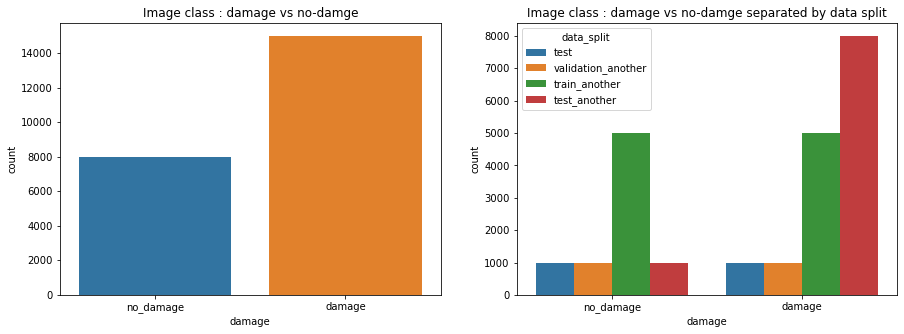

In [73]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='damage', data=sat_image_df, ax = ax[0])
ax[0].set_title('Image class : damage vs no-damge')
sns.countplot(x='damage', data=sat_image_df,hue='data_split', ax = ax[1])
ax[1].set_title('Image class : damage vs no-damge separated by data split')
plt.show()

In [77]:
print('Number of samples with class damage = {}'.format(len(sat_image_df[sat_image_df.damage == 'damage'])))
print('Number of samples with class no-damage = {}'.format(len(sat_image_df[sat_image_df.damage == 'no_damage'])))

Number of samples with class damage = 15000
Number of samples with class no-damage = 8000


In total the dataset include 23000 image samples. Of these 15000 (65%) images are with class damage, meaning they are flooded by the hiricane and the remaining 8000 (35%) are damage free. Though not 50-50 samples, 65-35 sample balance b/n damaged and no-damage is a reasonable distribution.

As can be seen in the second barplot, the data set comes in four groups:
- Training dataset : 8000 samples from each class
- validation dataset :  1000 samples from each class
- test dataset : 1000 samples from each class and
- Anothe test dataset : 8000 from damage class and 1000 no-damage class


In [34]:
# sat_image_df.to_csv('./data/huricane_damage_data.csv')

Now lets visualize the loaction and distribution of the data

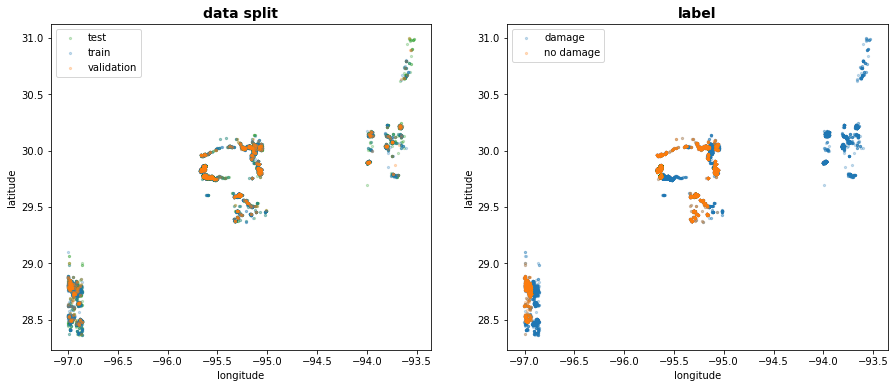

In [87]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

s = 5
alpha = 0.25

# get the train-validation-test splits
image_df_train = sat_image_df[sat_image_df['data_split']=='train_another'].copy()
image_df_val = sat_image_df[sat_image_df['data_split']=='validation_another'].copy()
image_df_test = sat_image_df[sat_image_df['data_split']=='test_another'].copy()

# sort to ensure reproducible behaviour
image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_test['lon'], image_df_test['lat'], color='C2', s=s, alpha=alpha, label='test')
ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')


ax[0].set_title('data split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = sat_image_df[sat_image_df['damage']=='damage'].copy()
image_df_nodmg = sat_image_df[sat_image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

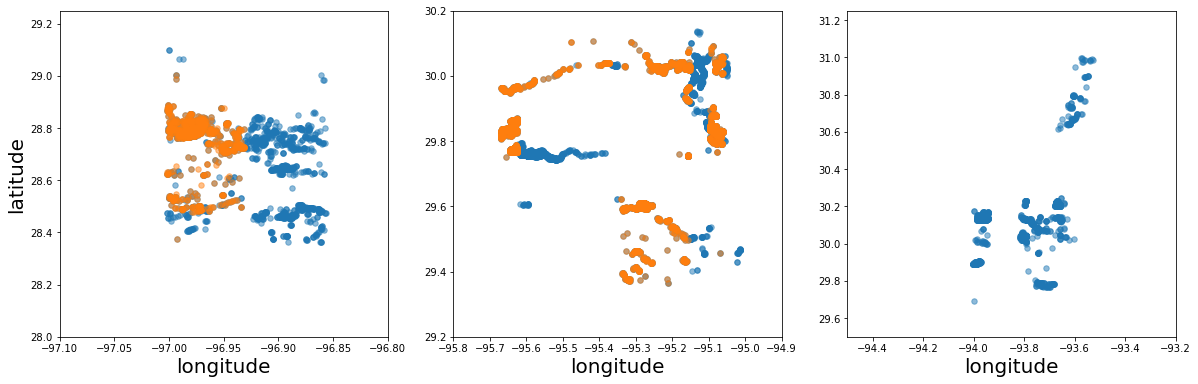

In [91]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

s = 30
alpha = 0.50

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[0].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[2].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[0].set_ylabel('latitude', fontsize=20)
ax[0].set_xlabel('longitude', fontsize=20)
ax[1].set_xlabel('longitude', fontsize=20)
ax[2].set_xlabel('longitude', fontsize=20)

ax[0].set_xlim(-97.1,-96.8)
ax[0].set_ylim(28.0,29.25)
ax[1].set_xlim(-95.8,-94.9)
ax[1].set_ylim(29.2,30.2)
ax[2].set_xlim(-94.5,-93.2)
ax[2].set_ylim(29.5,31.25)
plt.show(fig)

Write some obsrevation.
the thrid area is all flooded while the other two area have both.  

Observations from the above plots:
- The datastes sample three distinct geographic locations
- The training, validation and test sample the three locations very well, meaning they are distributed in all three locations.
- The samples from location three (NE location) are only damage class, while the other two have both classes.
- Even on the two location there seems to be a clear boundary b/n samples of damage and no-damage. This is mot surprising as flooding always affects neighborhoods.

<p>&nbsp;</p>

Next we create a montage of some sample images from each class

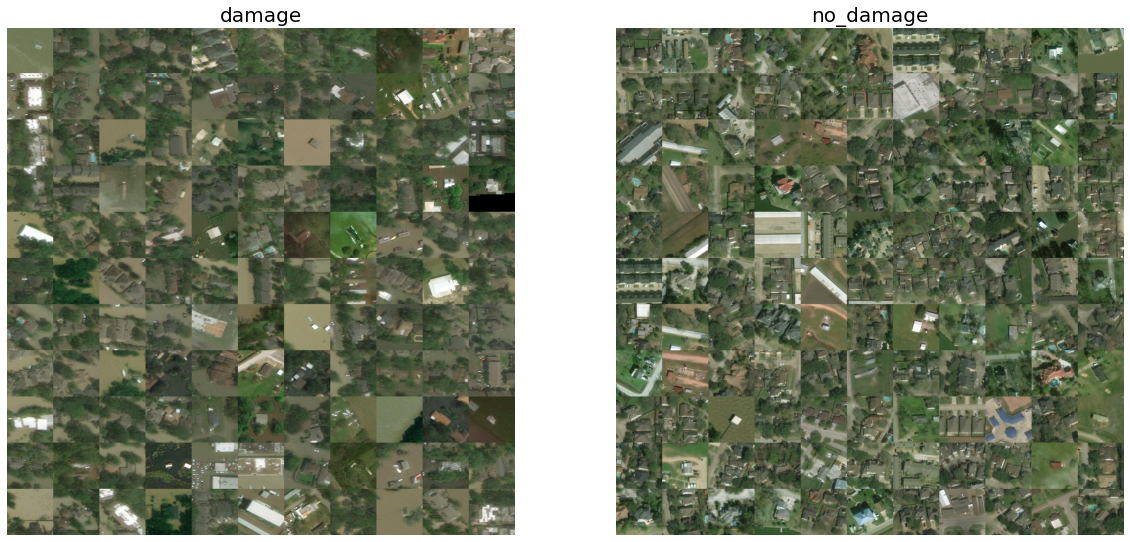

In [116]:
montage_rgb = lambda x, **kwargs: np.stack([montage(x[:, :, :, i], **kwargs) for i in range(x.shape[3])], -1)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for ax, (cat,rows) in zip(axes, sat_image_df.groupby(['damage'])):
    img_stack = np.stack(rows.sample(121)['path'].map(imread), 0)
    ax.imshow(montage_rgb(img_stack))
    ax.set_title(cat, fontsize=20)
    ax.axis('off')

#### Checking file size and channel

In [167]:
# read image
img_dimensions={}
for i in range(sat_image_df.shape[0]):
    img = cv2.imread(str(sat_image_df.iloc[i]['path']), cv2.IMREAD_UNCHANGED)

    # get dimensions of image
    img_dimensions[str(sat_image_df.iloc[i]['path'])] = {'height':img.shape[0],
                                                        'width':img.shape[1],
                                                        'channels':img.shape[2]}

In [168]:
img_dimensions_df = (pd.DataFrame(img_dimensions)).T

In [169]:
print('min height is {} and max height is {}'.format(img_dimensions_df['height'].min(),img_dimensions_df['height'].max()))
print('min height is {} and max width is {}'.format(img_dimensions_df['width'].min(),img_dimensions_df['width'].max()))
print('min # of channels is {} and max # of channels is {}'.format(img_dimensions_df['channels'].min(),img_dimensions_df['channels'].max()))

min height is 128 and max height is 128
min height is 128 and max width is 128
min # of channels is 3 and max # of channels is 3


- All the input datasets are color images with a size of 128 x 128

## 1.5 Summary

In this notebook we've read and QCied the input datasets. 
- We have 23000 images with two classes, 15000 of damaged class and the remaining 8000 with no-damage.
- The dataset cover three different geographic locations. Two of the location containf both type of classes while the third location have only damaged class
- All the input dataset are color images with a size of 128x128


In the next notebook (EDA), we will explore the data more